In [1]:
import os
import cv2
import face_recognition
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import imutils
from imutils import paths
import time
import math
import sys
from threading import Timer
import shutil
import time
#Tensor libraries for face/mask recognitions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream


#Tensor and etc libraries to train the models and datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import argparse

C:\Users\Coope\anaconda3\envs\Project_faceRec\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pathlib import Path

cwd = Path().resolve()
# cwd == PosixPath('/path/to/this/jupyter/ipynb/file's/directory/')
cwd

WindowsPath('C:/Users/Coope/Documents/FacerecoProject/Mask-Face-recog-Project')

In [35]:
#grabing dataset directory path
#grabbing model directory path to save h5 model file
dataset_path=os.getcwd()+"/dataset"
model_path=os.getcwd()+"/model/mask_model"

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
imagePaths = [imagePath.replace("\\","//",-1) for imagePath in imagePaths]
data = []
labels = []

[INFO] loading images...


In [6]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split("//")[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [7]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, stratify=labels, random_state=42)

In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [12]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\Coope\anaconda3\envs\Project_faceRec\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
57/57 [==============================] - 75s 1s/step - loss: 0.4041 - accuracy: 0.8434 - val_loss: 0.1383 - val_accuracy: 0.9918
Epoch 2/20
57/57 [==============================] - 66s 1s/step - loss: 0.1375 - accuracy: 0.9767 - val_loss: 0.0582 - val_accuracy: 0.9918
Epoch 3/20
57/57 [==============================] - 65s 1s/step - loss: 0.0680 - accuracy: 0.9895 - val_loss: 0.0390 - val_accuracy: 0.9951
Epoch 4/20
57/57 [==============================] - 66s 1s/step - loss: 0.0515 - accuracy: 0.9911 - val_loss: 0.0286 - val_accuracy: 0.9951
Epoch 5/20
57/57 [==============================] - 67s 1s/step - loss: 0.0409 - accuracy: 0.9933 - val_loss: 0.0245 - val_accuracy: 0.9951
Epoch 6/20
57/57 [==============================] - 66s 1s/step - loss: 0.0304 - accuracy: 0.9950 - val_loss: 0.0212 - val_accuracy: 0.9951
Epoch 7/20
57/57 [==============================] - 66s 1s/step - loss: 0.0273 - accuracy: 0.9956 - val_loss: 0.0205 - val_accuracy: 0.9

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
20/20 [==============================] - 12s 479ms/step


In [18]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       439
without_mask       0.99      0.99      0.99       172

    accuracy                           0.99       611
   macro avg       0.99      0.99      0.99       611
weighted avg       0.99      0.99      0.99       611



In [36]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(model_path+".h5")

[INFO] saving mask detector model...


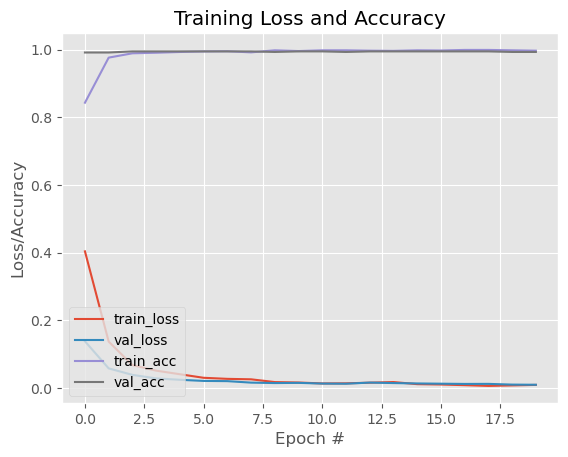

In [37]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [21]:
#The Start of the Facial Recognition Application
img_path = str(cwd) + "//Recog_Train"

In [22]:
images = []
class_names = []
encode_list = []
encode_list_cl = []
myList = os.listdir(img_path)

In [23]:
for subdir in os.listdir(img_path):
    path = img_path + '/' + subdir
    path = path + '/'
    for img in os.listdir(path):
        img_pic = path + img
        class_names.append(subdir)
        cur_img = cv2.imread(img_pic)
        cur_img = cv2.cvtColor(cur_img , cv2.COLOR_BGR2RGB)
        images.append(cur_img)

In [24]:
def detect_and_predict_mask(frame, faceNet, maskNet,threshold):
	# grab the dimensions of the frame and then construct a blob
	# from it
	global detections 
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),(104.0, 177.0, 123.0))
	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []
	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence >threshold:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)
            
			# add the face and bounding boxes to their respective
			# lists
			locs.append((startX, startY, endX, endY))
			#print(maskNet.predict(face)[0].tolist())
			preds.append(maskNet.predict(face)[0].tolist())
	return (locs, preds)

In [34]:
# SETTINGS
MASK_MODEL_PATH=os.getcwd()+"\\model\\mask_model.h5"
FACE_MODEL_PATH=str(cwd)+"\\masksdetection-master\\face_detector"
SOUND_PATH=str(cwd)+"\\masksdetection-master\\face_detector"
THRESHOLD = 0.5

In [26]:
# Load Sounds
from os.path import dirname, join

In [27]:
current_folder = globals()['_dh'][0]
current_folder

'C:\\Users\\Coope\\Documents\\FacerecoProject\\Mask-Face-recog-Project'

In [28]:
protoPath = join(current_folder, "deploy.prototxt")
weightsPath = join(current_folder, "res10_300x300_ssd_iter_140000.caffemodel")

In [39]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
faceNet = cv2.dnn.readNet(protoPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(MASK_MODEL_PATH)

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [40]:
# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(0).start()
time.sleep(2.0)
        
def find_encodings(images) :
        for img in images : 
            encodings = face_recognition.face_encodings(img)[0]
            encode_list.append(encodings)
       
        return encode_list
    
encodeListKnown = find_encodings(images)
 
cap = cv2.VideoCapture(0)

[INFO] starting video stream...


In [ ]:
while True : 
    success , img = cap.read()
    imgs = cv2.resize(img,(0,0),None,0.25,0.25)
    imgs = cv2.cvtColor(imgs , cv2.COLOR_BGR2RGB)
    (locs, preds) = detect_and_predict_mask(imgs, faceNet, maskNet,THRESHOLD)
    facesCurFrame = face_recognition.face_locations(imgs)
    encodeCurFrame  = face_recognition.face_encodings(imgs,facesCurFrame)
    
    for encodeFace , faceLoc , pred in zip(encodeCurFrame,facesCurFrame ,preds):
        (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        matches = face_recognition.compare_faces(encode_list, encodeFace)
        faceDis = face_recognition.face_distance(encode_list, encodeFace)
        matchIndex = np.argmin(faceDis)
        name = class_names[matchIndex]
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 
        y1,x2,y2,x1 = faceLoc
        y1,x2,y2,x1 = y1*4 , x2*4 , y2*4 , x1*4
        cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
        cv2.rectangle(img,(x1,y2-35),(x2,y2),color, cv2.FILLED)
        cv2.putText(img, name, (x1+6 , y2 - 6),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2 )
        cv2.putText(img, label, (x1 , y2+10) , cv2.FONT_HERSHEY_COMPLEX , 1 , (255,0,255) , 2)
        
        cv2.imshow('Project' , img)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord("q"):
            break
        
cv2.destroyAllWindows()
vs.stop()

1/1 [==============================] - 0s 48ms/step
